# **Introduction**
This codebook will demonstrate working on the Prophet algorithm using the Adobe historical stock dataset. Prophet is a time series forecasting model introduced by Facebook. Designed to be simple and powerful, this is one of the state of the art time series forecasting models.

# **Importing Libraries**
At first, I'll import all the necessary libraries for this process. Each library contains a small comment on it's utility and necessity. 

In [22]:
# Install required packages
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "prophet"])

0

In [23]:
# import necessary libraries
import numpy as np #for powerful array and fast math operations
import pandas as pd #for creating and working on dataframes
import matplotlib.pyplot as plt #for creating plots and charts
import seaborn as sns #another visualization library for better and easier plots
import kagglehub #for interacting with kaggle to download datasets
import os #for interacting with the os to read csv
from prophet import Prophet #importing the prophet library
from prophet.make_holidays import make_holidays_df #importing holidays for the algorithm
from prophet.diagnostics import cross_validation, performance_metrics #importing cross validation and performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #importing metrics to evaluate the models
from prophet.plot import plot_cross_validation_metric #for plotting cross validation metrics
import logging #for suppressing warnings

# **Loading the Dataset**
The dataset used here is Adobe's historical stock data. The dataset is downloaded directly from kaggle using the kagglehub library. And I used the os library to interact with the operating system to make it read the csv. This method ensures the loading of the latest version of the dataset without any manual intercation. 
After loading the data, the first step is observing the first few rows and the data types of each column to get primary insights.

In [24]:
# Download latest version of the dataset
path = kagglehub.dataset_download("paultimothymooney/stock-market-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Raiyan\.cache\kagglehub\datasets\paultimothymooney\stock-market-data\versions\74


In [25]:
# `path` points to the downloaded dataset directory
dataset_dir = path

# List files in the dataset directory to identify the data files
print("Files in dataset directory:", os.listdir(dataset_dir))

Files in dataset directory: ['stock_market_data']


In [26]:
# Load Adobe stock data
adbe_path = os.path.join(dataset_dir, "stock_market_data", "nasdaq", "csv", "ADBE.csv")
adbe_df = pd.read_csv(adbe_path)

# Inspect first rows
print(adbe_df.head())
print(adbe_df.info())

         Date       Low  Open    Volume      High     Close  Adjusted Close
0  13-08-1986  0.210938   0.0  18899200  0.218750  0.210938        0.198057
1  14-08-1986  0.222656   0.0   4160000  0.230469  0.222656        0.209060
2  15-08-1986  0.218750   0.0   4332800  0.222656  0.218750        0.205392
3  18-08-1986  0.210938   0.0   2828800  0.218750  0.210938        0.198057
4  19-08-1986  0.214844   0.0   2060800  0.218750  0.214844        0.201725
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9158 entries, 0 to 9157
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            9158 non-null   object 
 1   Low             9158 non-null   float64
 2   Open            9158 non-null   float64
 3   Volume          9158 non-null   int64  
 4   High            9158 non-null   float64
 5   Close           9158 non-null   float64
 6   Adjusted Close  9158 non-null   float64
dtypes: float64(5), int64(1), obj

# **Data Preprocessing**
## Datetime Conversion
The output from the last cell showed that the 'Date' column contains object datatype. But Prophet requires the date in the datetime format. Therefore the datatype for Date column must be converted.

In [27]:
# Turning dates into datetime format
adbe_df['Date'] = pd.to_datetime(adbe_df['Date'], dayfirst = True)

In [28]:
adbe_df.tail(n=20)

,Date,Low,Open,Volume,High,Close,Adjusted Close
9138,2022-11-14,334.429993,338.070007,3464500,345.109985,340.369995,340.369995
9139,2022-11-15,342.559998,348.410004,2948600,350.970001,345.959991,345.959991
9140,2022-11-16,336.720001,345.000000,2123200,345.019989,338.410004,338.410004
9141,2022-11-17,329.350006,331.739990,2740400,339.869995,337.829987,337.829987
9142,2022-11-18,329.140015,344.299988,3421700,344.700012,330.859985,330.859985
9143,2022-11-21,320.600006,329.529999,3219900,330.250000,321.489990,321.489990
9144,2022-11-22,320.200012,322.489990,2573800,331.540009,330.880005,330.880005
9145,2022-11-23,327.589996,329.929993,2240800,338.500000,335.779999,335.779999
9146,2022-11-25,332.010010,332.890015,1197800,335.510010,334.299988,334.299988
9147,2022-11-28,328.070007,335.829987,2314800,338.190002,328.970001,328.970001


## Checking for Missing Values
Now the dataset needs to be checked for any missing dates. Although Prophet is designed to handle missing dates well, this check is to see the amount of missing dates and if interpolation is necessary.
For this, I'll first find out the total range of date the data spans over. From this, I'll calculate the total calendar days. Then I'll subtract from it the available dates in my dataset, the holidays, and the weekends. This will give me all the missing dates.

In [29]:
# Find the total number of dates available in the dataset
start_date = adbe_df['Date'].min()
end_date = adbe_df['Date'].max()

print(f"Date range: {start_date} to {end_date}")

Date range: 1986-08-13 00:00:00 to 2022-12-12 00:00:00


In [30]:
# Calculate the total number of calendar days in the timeline
full_timeline = pd.date_range(start=start_date, end=end_date, freq='D')
total_calendar_days = len(full_timeline)
# Calculate the number of days available in the dataset
available_data_days = len(adbe_df)
print(f"Total calendar days in the timeline: {total_calendar_days}")
print(f"Number of days with available data: {available_data_days}")

Total calendar days in the timeline: 13271
Number of days with available data: 9158


In [31]:
# Calculate the number of weekends in the timeline
number_of_weekends = sum(full_timeline.dayofweek >= 5)
print(f"Number of weekend days (Sat/Sun): {number_of_weekends}")

Number of weekend days (Sat/Sun): 3792


In [32]:
# Calculate the number of holidays for the period
year_list = range(start_date.year, end_date.year + 1)
holidays_df = make_holidays_df(year_list=year_list, country='US')
# Filter holidays to be within the timeline and not on a weekend
holidays_in_timeline = holidays_df[(holidays_df['ds'] >= start_date) & (holidays_df['ds'] <= end_date) & (holidays_df['ds'].dt.dayofweek < 5)]
number_of_holidays = len(holidays_in_timeline)
print(f"Number of public holiday weekdays: {number_of_holidays}")

Number of public holiday weekdays: 366


In [33]:
# find the days that are missing on the dataset
missing_days = total_calendar_days - available_data_days - number_of_weekends - number_of_holidays
print(f"Missing days in the dataset: {missing_days}")

Missing days in the dataset: -45


Here the negative number is because prophet's holiday library includes some holidays on which stock market stays open. Since the number is only 45 in the span of 36 years, this is minimal and therefore it is ignoreable.

## Deciding on the Train and Test datasets
Now I'll first visualize the data (Adjusted Close Price in this case) to see the overall pattern. The pattern is mostly static, and after 2012 and then shows upward momentum and fluctuations. Therefore I'll take the training data from 2014. Also the data shows very high volatility from 2020, mostly due to the COVID pandemic. Therefore, I'll take the training data up to 2018 and the testing data up to 2019 to avoid this massive volatility.

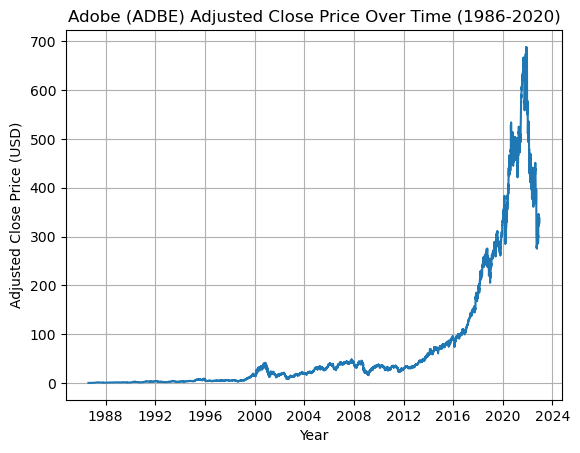

In [34]:
# Plot the 'Adjusted Close' price against the 'Date'
plt.plot(adbe_df['Date'], adbe_df['Adjusted Close'])

# Add a title and labels
plt.title('Adobe (ADBE) Adjusted Close Price Over Time (1986-2020)')
plt.xlabel('Year')
plt.ylabel('Adjusted Close Price (USD)')

# Add a grid for easier analysis
plt.grid(True)

# Display the plot
plt.show()

In [35]:
# Filter a range for model training
start_date = '2014-01-01'
end_date = '2018-12-31'

# Filter ADBE stock
adbe_train = adbe_df[(adbe_df['Date'] >= start_date) & (adbe_df['Date'] <= end_date)].copy()

adbe_train = adbe_train.set_index('Date')

In [36]:
# inspect the dataset
adbe_train.head(n=20)

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,
2014-01-02,58.939999,59.060001,2745900,59.529999,59.290001,59.290001
2014-01-03,59.110001,59.189999,1589000,59.689999,59.160000,59.160000
2014-01-06,58.009998,58.060001,3753600,58.770000,58.119999,58.119999
2014-01-07,58.060001,58.259998,2963600,59.049999,58.970001,58.970001
2014-01-08,58.459999,59.119999,3456000,59.279999,58.900002,58.900002
2014-01-09,58.720001,58.990002,2427400,59.529999,59.090000,59.090000
2014-01-10,58.950001,59.349998,1829100,59.630001,59.529999,59.529999
2014-01-13,58.410000,59.279999,2928700,59.439999,58.599998,58.599998
2014-01-14,58.630001,58.680000,4179500,60.529999,60.369999,60.369999


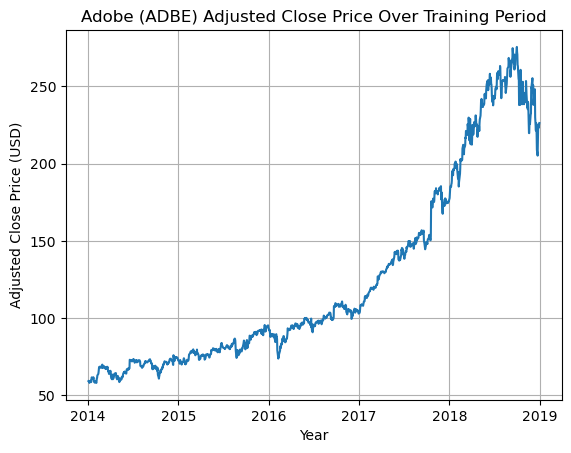

In [37]:
# Plot the 'Adjusted Close' price against the 'Date'
plt.plot(adbe_train['Adjusted Close'])

# Add a title and labels
plt.title('Adobe (ADBE) Adjusted Close Price Over Training Period')
plt.xlabel('Year')
plt.ylabel('Adjusted Close Price (USD)')

# Add a grid for easier analysis
plt.grid(True)

# Display the plot
plt.show()

## Check for Duplicates 
Now I'll check for any duplicates dates, because each date should only have one value for each of the columns, and therefore only one row.

In [38]:
# check for duplictaes
duplicate = adbe_train.reset_index().duplicated(subset=['Date'])
adbe_train[duplicate.values]

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,


## Pairplot Analysis
The pairplot analysis tells us each pair of variables' relationships. It shows us all the price variables are highly correlated showing a straight line. But the volume doesn't move together with price. However this is expected from stock data, because high volume can be related to both high and low prices. There is a small visible gap in the plot, which is caused by a massive price jump that basically created 2 clusters on the top and the bottom.

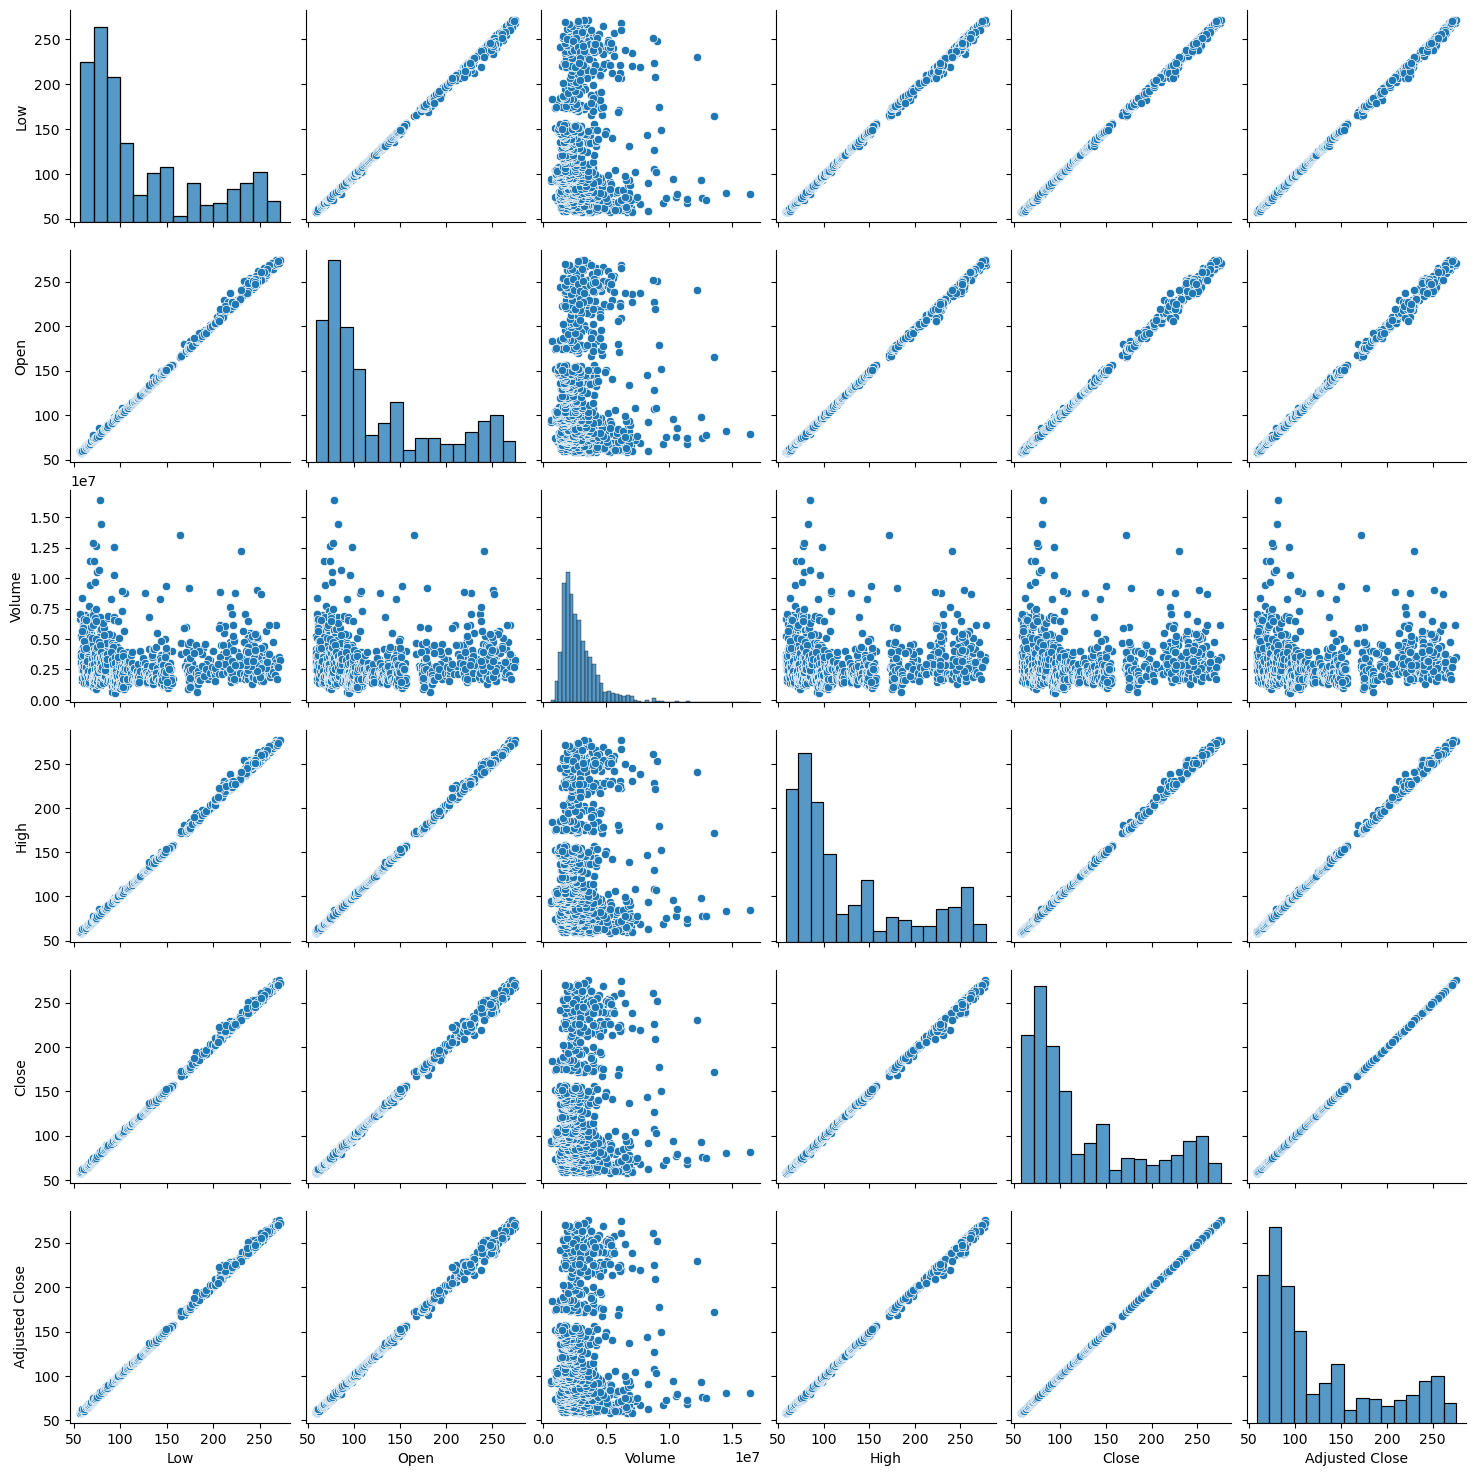

In [39]:
sns.pairplot(adbe_train)
plt.show()

## Creating a Prophet-Ready Dataframe
Prophet requires only 2 columns; the 'Dates' column named 'ds', and the column we'll predict (here 'Adjusted Close') to be named 'y'. So now I'll prepare the dataframe similarly so I can feed it to Prophet.

In [40]:
train_df = adbe_train[['Adjusted Close']].reset_index()
train_df.rename(columns={'Date': 'ds', 'Adjusted Close': 'y'}, inplace=True)
train_df.head(n=20)

,ds,y
0,2014-01-02,59.290001
1,2014-01-03,59.160000
2,2014-01-06,58.119999
3,2014-01-07,58.970001
4,2014-01-08,58.900002
5,2014-01-09,59.090000
6,2014-01-10,59.529999
7,2014-01-13,58.599998
8,2014-01-14,60.369999
9,2014-01-15,61.680000


## Log Transformation
Since my data shows high variance, I'll log transform the target variable so that the variance is stabilized.

In [41]:
# log transformation
train_df_log = train_df.copy()
train_df_log['y'] = np.log1p(train_df_log['y'])
train_df_log.head(n=10)

,ds,y
0,2014-01-02,4.099166
1,2014-01-03,4.097008
2,2014-01-06,4.079569
3,2014-01-07,4.093844
4,2014-01-08,4.092677
5,2014-01-09,4.095843
6,2014-01-10,4.103139
7,2014-01-13,4.087656
8,2014-01-14,4.116921
9,2014-01-15,4.138042


# **Model Training**
Now I'll start model training. I'll train 2 models. I'll train the first one without any added regressors. Then I'll add some regressors to see if that helps the model's predictions.

# Model 1
## Training Parameters
I'll use the same train size, horizon, and storage for metrics among the models for comparability. I'll train on 80% of data, and then cross-validate using a 60 day horizon.

## Model Tuning
I'll set the daily seasonality to False as I don't have any hourly data. I'll use weekly, yearly, and quarterly (added) seasonality. I'll provide the US holidays data as holidays. And I'll use Prophet's built in cross validation function to train this model.

## Metrics
I'll calculate and show the MAE, RMSE, MAPE, and R² value of the model. I'll also calculate average width and coverage to see if the model is overconfident or overfitting.

In [42]:
# Parameters for model traininng
initial_train_size = int(0.8 * len(train_df_log))
horizon = 60
n_iterations = (len(train_df_log) - initial_train_size) // horizon

# Storage for metrics
metrics_1 = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

In [43]:
# Make holidays DataFrame for US
holidays = make_holidays_df(year_list=range(1986, 2022), country='US')

In [ ]:
# Train Model 1 (Without any added regressors)
# Suppress warnings using logging
logging.getLogger('prophet').setLevel(logging.ERROR)

# Initialize and tune Prophet with built-in components
model_1 = Prophet(
    growth='linear', #assuming data grows and shrinks at steady rate without caps
    daily_seasonality=False, #since there's no hourly data
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive', #because the data is log-transformed
    changepoint_prior_scale=1, #higher value for more flexibility and trend changes
    interval_width=0.95, #95% confidence interval
    uncertainty_samples=1000, #more samples for more stable interval
    seasonality_prior_scale=0.1, #small to smooth out the seasonality to reduce overfitting
    holidays=holidays
)

# Add quarterly seasonality to reflect quaterly patterns
model_1.add_seasonality(name='quarterly', period=91.3, fourier_order=5) #stock data usually show quarterly seasonality

print(f"\nTraining Prophet on {len(train_df_log)} data points")
model_1.fit(train_df_log)

# Cross-validation with parameter tuning
print(f"\nRunning cross-validation:")
print(f"  Initial training size: {initial_train_size} days (80% of data)")
print(f"  Horizon: {horizon} days")
print(f"  Number of folds: {n_iterations}")

df_cv = cross_validation(
    model_1,
    initial=f'{initial_train_size} days',
    horizon=f'{horizon} days',
    period=f'{horizon} days'
)

print(f"  Total predictions made: {len(df_cv)}")

# Reverse log transformation for actual scale metrics
df_cv['y_actual'] = np.expm1(df_cv['y'])
df_cv['yhat_actual'] = np.expm1(df_cv['yhat'])
df_cv['yhat_lower_actual'] = np.expm1(df_cv['yhat_lower'])
df_cv['yhat_upper_actual'] = np.expm1(df_cv['yhat_upper'])

# Store predictions dataframe
predictions_cv_no_regressors = df_cv.copy()

# Calculate metrics in original scale
mae = mean_absolute_error(df_cv['y_actual'], df_cv['yhat_actual'])
rmse = np.sqrt(mean_squared_error(df_cv['y_actual'], df_cv['yhat_actual']))
mape = np.mean(np.abs((df_cv['y_actual'] - df_cv['yhat_actual']) / (df_cv['y_actual'] + 1e-8))) * 100
r2 = r2_score(df_cv['y_actual'], df_cv['yhat_actual'])

# Coverage analysis
in_interval = np.sum((df_cv['y_actual'] >= df_cv['yhat_lower_actual']) &
                     (df_cv['y_actual'] <= df_cv['yhat_upper_actual']))
coverage_pct = (in_interval / len(df_cv)) * 100
avg_width_pct = np.mean((df_cv['yhat_upper_actual'] - df_cv['yhat_lower_actual']) /
                        df_cv['y_actual']) * 100

In [45]:
# print the metrics
print(f"\nCross-Validation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"Prediction Interval Coverage: {coverage_pct:.2f}%")
print(f"Average Prediction Interval Width: {avg_width_pct:.2f}%")


Cross-Validation Metrics:
MAE: 10.95
RMSE: 13.52
MAPE: 6.30%
R²: 0.9354
Prediction Interval Coverage: 81.68%
Average Prediction Interval Width: 24.79%


## Metrics Discussion (Model 1)
The model is decent in following general trend with a low average error of 6.3%. The MAE and RMSE show moderate error metrics, although they're low relative to the stock prices as seen by the MAPE. The higher RMSE means that on some days the model's predictions were worse, probably due to earnings announcements, news events, and such events that weren't included in the holidays dataset. However, the low average width, and the coverage below the uncertainty interval indicates a somewhat overconfident model. However, the coverage and average width values are somewhat approximate as they're computed in real scale, not the log transformed scale where the model actually functioned. The R² value is very high indicating the model is good in following the direction of movement.

## Components Visualization
Now I'll visualize all the components (the trend, seasonalities, and holidays effects). Prophet is basically an additive model that breaks the time series in these components, and therefore these can be visualized esaily using Prophet's built in plot_components. This gives us a clear idea about the patterns.

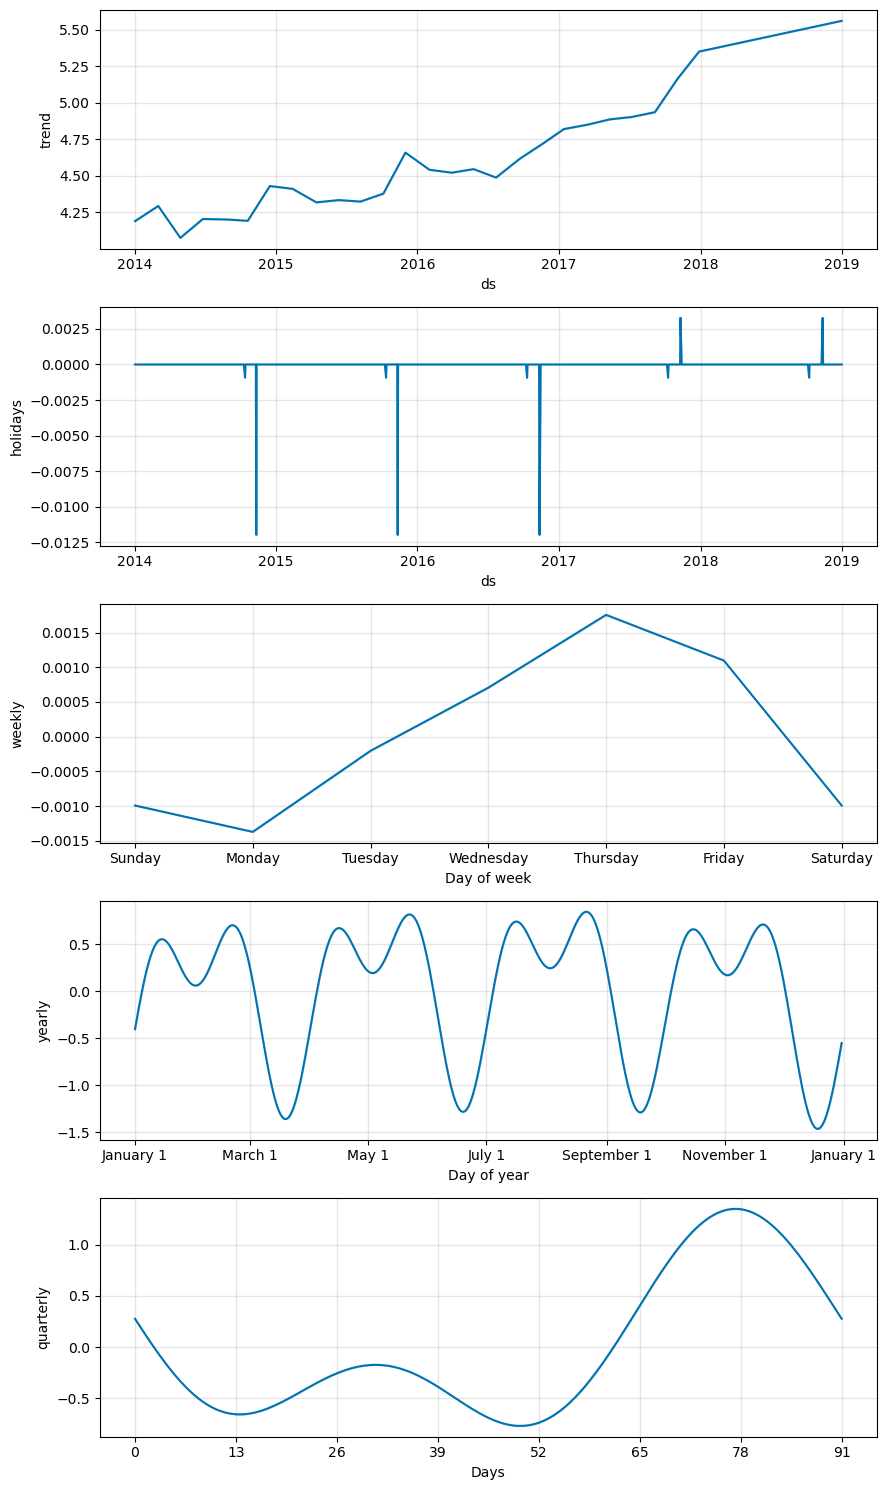

In [46]:
# Visualize all the components of the dataset
forecast_model_1 = model_1.predict(train_df_log)

figure_1 = model_1.plot_components(forecast_model_1)
plt.show()

## Metric Visualization
Now I'll visualize the MAPE metric. It shows a different value from the calculated results because it's calculated in the log transformed space. Although the metric shows better value at a lower horizon, we'll still use a 60 day horizon due to bias-variance trade-off.

c:\Users\Raiyan\anaconda3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\Raiyan\anaconda3\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


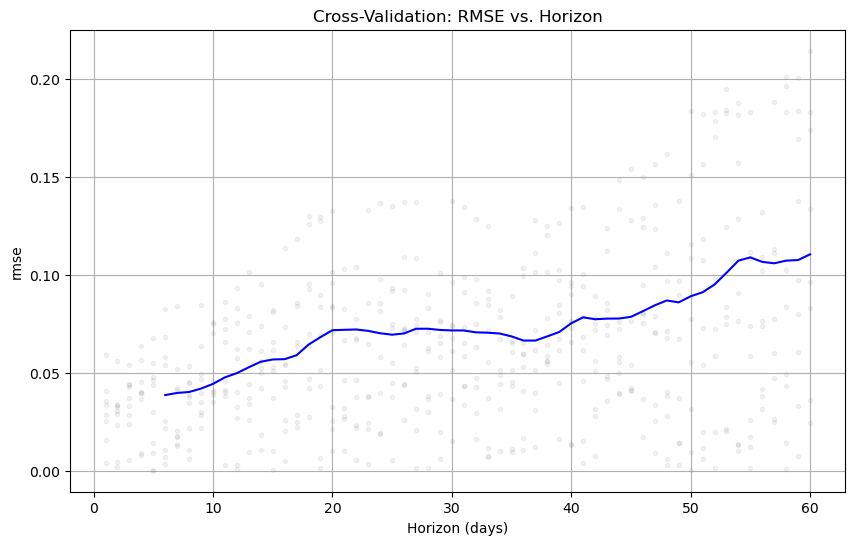

In [47]:
# We can change 'mape' to 'rmse', 'mae', or 'mape'.
figure_2 = plot_cross_validation_metric(df_cv, metric='rmse')
plt.title("Cross-Validation: RMSE vs. Horizon")
plt.show()

# Model 2
In this model, I introduce additional regressors to evaluate whether they improve predictive performance. Future regressor values are generated using autoregressive logic based on past data. The training size, forecast horizon, and evaluation metrics remain the same as in Model 1.
Instead of Prophet’s built-in cross-validation, this model applies a walk-forward expanding-window approach (also known as the candlestick method). In each iteration, the model trains up to a given point, forecasts for the specified horizon, and then expands the training window by that horizon.
However, this model is not fully recursive. It predicts one day ahead in each iteration, using the actual regressor values available up to the previous day rather than recursively feeding in its own predicted regressors. This setup offers a realistic and robust evaluation, since it mirrors how forecasts are generated in real-world scenarios where new data arrives daily, making it particularly effective for assessing Prophet’s stability and the impact of regressors over time.

## Regressors
### Lag 1 and 7:
Lag variables are basically previous days' closing prices. They are closing prices of yesterday and 1 week before.
### SMA 30:
This is the 30 days simple moving average of the Adjusted Close Price.
### Volatility 30:
This is the 30 days rolling standard deviation of the Adjusted Close Price.
### Trend Strength
This measures the deviation of previous day's price from the simple moving average of 30 days. It captures the comparative direction and strength of current trend.

In [48]:
# Parameters for iterative traininng
initial_train_size = int(0.8 * len(train_df_log))
horizon = 60
n_iterations = (len(train_df_log) - initial_train_size) // horizon

In [49]:
# Storage for metrics
metrics = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

In [ ]:
# Walk forward validation and performance metrics with autoregression
# Main Walk-Forward Loop
train_end = initial_train_size
all_fold_forecasts = []
coverage_metrics = {'in_coverage': [], 'coverage_width': []}

# Store all predictions for later visualization
all_predictions_list = []

for i in range(n_iterations):
    # Define current training and testing windows
    current_train = train_df_log.iloc[:train_end].copy()
    test_start = train_end
    test_end = min(train_end + horizon, len(train_df_log))
    test_df = train_df_log.iloc[test_start:test_end].copy()

    if len(test_df) == 0:
        break

    print(f"Iteration {i+1}/{n_iterations}: Training on {len(current_train)} data points, testing on {len(test_df)}.")

    # Recalculate features on the loop to avoid leakage
    current_train_clean = current_train[['ds', 'y']].copy()

    # Include basic lags
    current_train_clean['lag1'] = current_train_clean['y'].shift(1)
    current_train_clean['lag7'] = current_train_clean['y'].shift(7)

    # Include moving averages
    current_train_clean['sma_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).mean()

    # Include volatility (rolling std)
    current_train_clean['volatility_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).std()

    # Include trend strength (price relative to moving average)
    current_train_clean['trend_strength'] = current_train_clean['y'] - current_train_clean['sma_30']

    # Drop rows with NaN
    current_train_clean = current_train_clean.dropna()

    if len(current_train_clean) < 50:
        print("  Insufficient training data after feature engineering. Skipping.")
        continue

    # Initialize and Fit Model with Reduced Seasonality
    model_2 = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='additive',
        changepoint_prior_scale=1,  
        interval_width=0.95,
        uncertainty_samples=1000,
        seasonality_prior_scale=0.1,
        holidays=holidays
    )

    # Add regressors to the model
    regressors = ['lag1', 'lag7', 'sma_30', 'volatility_30', 'trend_strength']

    for reg in regressors:
        model_2.add_regressor(reg)
    model_2.add_seasonality(name='quarterly', period=91.3, fourier_order=5)

    model_2.fit(current_train_clean)

    # Forecasting with Actual Values (not recursive)
    history_y = current_train_clean['y'].values.tolist()
    fold_predictions = []
    actual_dates = test_df['ds'].values

    for step in range(len(test_df)):
        # Create future dataframe
        future_step_df = pd.DataFrame({'ds': [actual_dates[step]]})

        # Calculate regressors from history
        history_array = np.array(history_y)

        future_step_df['lag1'] = history_array[-1]
        future_step_df['lag7'] = history_array[-7] if len(history_array) >= 7 else history_array[0]

        future_step_df['sma_30'] = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()

        future_step_df['volatility_30'] = np.std(history_array[-30:]) if len(history_array) >= 30 else 0

        sma_30_current = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()
        future_step_df['trend_strength'] = history_array[-1] - sma_30_current

        # Make prediction with intervals
        forecast_step = model_2.predict(future_step_df)
        fold_predictions.append(forecast_step)

        # Use actual value for next iteration
        actual_log_value = test_df.iloc[step]['y']
        history_y.append(actual_log_value)

    # Calculate Metrics with Coverage
    fold_forecast_df = pd.concat(fold_predictions).reset_index(drop=True)
    all_fold_forecasts.append(fold_forecast_df)

    # Reverse log transformation
    y_true_original_2 = np.expm1(test_df['y'].values)
    y_pred_original_2 = np.expm1(fold_forecast_df['yhat'].values)
    y_lower_original_2 = np.expm1(fold_forecast_df['yhat_lower'].values)
    y_upper_original_2 = np.expm1(fold_forecast_df['yhat_upper'].values)

    # Store predictions for this fold
    for j in range(len(test_df)):
        all_predictions_list.append({
            'ds': test_df.iloc[j]['ds'],
            'y_actual_log': test_df.iloc[j]['y'],
            'y_actual': y_true_original_2[j],
            'y_pred_log': fold_forecast_df.iloc[j]['yhat'],
            'y_pred': y_pred_original_2[j],
            'y_lower_log': fold_forecast_df.iloc[j]['yhat_lower'],
            'y_lower': y_lower_original_2[j],
            'y_upper_log': fold_forecast_df.iloc[j]['yhat_upper'],
            'y_upper': y_upper_original_2[j],
            'fold': i + 1
        })

    # Standard metrics
    mae = mean_absolute_error(y_true_original_2, y_pred_original_2)
    rmse = np.sqrt(mean_squared_error(y_true_original_2, y_pred_original_2))
    mape = np.mean(np.abs((y_true_original_2 - y_pred_original_2) / (y_true_original_2 + 1e-8))) * 100
    r2 = r2_score(y_true_original_2, y_pred_original_2)

    # Coverage metrics
    in_interval = np.sum((y_true_original_2 >= y_lower_original_2) & (y_true_original_2 <= y_upper_original_2))
    coverage = (in_interval / len(y_true_original_2)) * 100
    avg_interval_width = np.mean(y_upper_original_2 - y_lower_original_2)
    avg_interval_width_pct = np.mean((y_upper_original_2 - y_lower_original_2) / y_true_original_2) * 100


    metrics['mae'].append(mae)
    metrics['rmse'].append(rmse)
    metrics['mape'].append(mape)
    metrics['r2'].append(r2)
    coverage_metrics['in_coverage'].append(coverage)
    coverage_metrics['coverage_width'].append(avg_interval_width_pct)

    # Move the training window (candlestick method)
    train_end += horizon

    print(f"    MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")
    print(f"    Coverage: {coverage:.1f}% | Avg Width: {avg_interval_width_pct:.1f}%")

# Create comprehensive predictions dataframe
predictions_df_with_regressors_nr = pd.DataFrame(all_predictions_list)

In [51]:
# print the metrics
avg_mae = np.mean(metrics['mae'])
avg_rmse = np.mean(metrics['rmse'])
avg_mape = np.mean(metrics['mape'])
avg_r2 = np.mean(metrics['r2'])
print(f"\nOverall Metrics with Regressors (Non-Recursive):")
print(f"  MAE: {avg_mae:.2f}")
print(f"  RMSE: {avg_rmse:.2f}")
print(f"  MAPE: {avg_mape:.2f}%")
print(f"  R²: {avg_r2:.4f}")
avg_coverage = np.mean(coverage_metrics['in_coverage'])
avg_width = np.mean(coverage_metrics['coverage_width'])
print(f"  Coverage: {avg_coverage:.1f}%")
print(f"  Coverage Width: {avg_width:.1f}%")


Overall Metrics with Regressors (Non-Recursive):
  MAE: 3.53
  RMSE: 4.74
  MAPE: 1.50%
  R²: 0.8293
  Coverage: 11.2%
  Coverage Width: 0.4%


## Metrics Discussion (Model 2)
These metrics show that the model is extremely accurate with at one step ahead predictions, with a very tiny average error of 1.5%. The other error metrics are also very low with decent R² value. However, the model is very overconfident with very little coverage and very narrow width. This is due to the data leakage issue, showing that this model is worse at predicting general market movements.

## Model 3
Although I'm experimenting with 2 models, I will now train a 3rd model to adrress the limitations of Model 2. This model will be truly recursive in nature (will use it's own predictions for regressors for the horizon, and not the actual values). I'll keep everything else as is.
however, as this model uses it's own predictions for a long horizon, the errors can compound exponentially resulting in deteriorated metrics.

In [52]:
# Parameters for iterative traininng
initial_train_size = int(0.8 * len(train_df_log))
horizon = 14
n_iterations = (len(train_df_log) - initial_train_size) // horizon
# Storage for metrics
metrics = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

In [ ]:
# Walk forward validation and performance metrics with autoregression (True Recursive)
# Main Walk-Forward Loop
train_end = initial_train_size
all_fold_forecasts = []
coverage_metrics = {'in_coverage': [], 'coverage_width': []}

# Store all predictions for later visualization
all_predictions_list = []

for i in range(n_iterations):
    # Define current training and testing windows
    current_train = train_df_log.iloc[:train_end].copy()
    test_start = train_end
    test_end = min(train_end + horizon, len(train_df_log))
    test_df = train_df_log.iloc[test_start:test_end].copy()

    if len(test_df) == 0:
        break

    print(f"Iteration {i+1}/{n_iterations}: Training on {len(current_train)} data points, testing on {len(test_df)}.")

    # Recalculate features on the loop to avoid leakage
    current_train_clean = current_train[['ds', 'y']].copy()

    # Include basic lags
    current_train_clean['lag1'] = current_train_clean['y'].shift(1)
    current_train_clean['lag7'] = current_train_clean['y'].shift(7)

    # Include moving averages
    current_train_clean['sma_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).mean()

    current_train_clean['volatility_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).std()

    # Include trend strength (price relative to moving average)
    current_train_clean['trend_strength'] = current_train_clean['y'] - current_train_clean['sma_30']

    # Drop rows with NaN
    current_train_clean = current_train_clean.dropna()

    if len(current_train_clean) < 50:
        print("  Insufficient training data after feature engineering. Skipping.")
        continue

    # Initialize and Fit Model with Reduced Seasonality
    model_3 = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='additive',
        changepoint_prior_scale=1,  
        interval_width=0.95,
        uncertainty_samples=1000,
        seasonality_prior_scale=0.1,
        holidays=holidays
    )

    # Add regressors to the model
    regressors = ['lag1', 'lag7', 'sma_30', 'volatility_30', 'trend_strength'] 

    for reg in regressors:
        model_3.add_regressor(reg)
    model_3.add_seasonality(name='quarterly', period=91.3, fourier_order=5)

    model_3.fit(current_train_clean)

    # TRUE RECURSIVE Forecasting (using predicted values)
    history_y = current_train_clean['y'].values.tolist()
    fold_predictions = []
    actual_dates = test_df['ds'].values

    for step in range(len(test_df)):
        # Create future dataframe
        future_step_df = pd.DataFrame({'ds': [actual_dates[step]]})

        # Calculate regressors from history
        history_array = np.array(history_y)

        future_step_df['lag1'] = history_array[-1]
        future_step_df['lag7'] = history_array[-7] if len(history_array) >= 7 else history_array[0]

        future_step_df['sma_30'] = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()

        future_step_df['volatility_30'] = np.std(history_array[-30:]) if len(history_array) >= 30 else 0

        sma_30_current = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()
        future_step_df['trend_strength'] = history_array[-1] - sma_30_current

        # Make prediction with intervals
        forecast_step = model_3.predict(future_step_df)
        fold_predictions.append(forecast_step)

        # TRUE RECURSIVE: Use PREDICTED value for next iteration
        predicted_log_value = forecast_step['yhat'].values[0]
        history_y.append(predicted_log_value)

    # Calculate Metrics with Coverage
    fold_forecast_df = pd.concat(fold_predictions).reset_index(drop=True)
    all_fold_forecasts.append(fold_forecast_df)

    # Reverse log transformation
    y_true_original_2 = np.expm1(test_df['y'].values)
    y_pred_original_2 = np.expm1(fold_forecast_df['yhat'].values)
    y_lower_original_2 = np.expm1(fold_forecast_df['yhat_lower'].values)
    y_upper_original_2 = np.expm1(fold_forecast_df['yhat_upper'].values)

    # Store predictions for this fold
    for j in range(len(test_df)):
        all_predictions_list.append({
            'ds': test_df.iloc[j]['ds'],
            'y_actual_log': test_df.iloc[j]['y'],
            'y_actual': y_true_original_2[j],
            'y_pred_log': fold_forecast_df.iloc[j]['yhat'],
            'y_pred': y_pred_original_2[j],
            'y_lower_log': fold_forecast_df.iloc[j]['yhat_lower'],
            'y_lower': y_lower_original_2[j],
            'y_upper_log': fold_forecast_df.iloc[j]['yhat_upper'],
            'y_upper': y_upper_original_2[j],
            'fold': i + 1
        })

    # Standard metrics
    mae = mean_absolute_error(y_true_original_2, y_pred_original_2)
    rmse = np.sqrt(mean_squared_error(y_true_original_2, y_pred_original_2))
    mape = np.mean(np.abs((y_true_original_2 - y_pred_original_2) / (y_true_original_2 + 1e-8))) * 100
    r2 = r2_score(y_true_original_2, y_pred_original_2)

    # Coverage metrics
    in_interval = np.sum((y_true_original_2 >= y_lower_original_2) & (y_true_original_2 <= y_upper_original_2))
    coverage = (in_interval / len(y_true_original_2)) * 100
    avg_interval_width = np.mean(y_upper_original_2 - y_lower_original_2)
    avg_interval_width_pct = np.mean((y_upper_original_2 - y_lower_original_2) / y_true_original_2) * 100

    metrics['mae'].append(mae)
    metrics['rmse'].append(rmse)
    metrics['mape'].append(mape)
    metrics['r2'].append(r2)
    coverage_metrics['in_coverage'].append(coverage)
    coverage_metrics['coverage_width'].append(avg_interval_width_pct)

    # Move the training window (candlestick method)
    train_end += horizon

    print(f"    MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")
    print(f"    Coverage: {coverage:.1f}% | Avg Width: {avg_interval_width_pct:.1f}%")

# Create comprehensive predictions dataframe
predictions_df_with_regressors = pd.DataFrame(all_predictions_list)


In [54]:
# Aggregate and Display Final Metrics
print("AGGREGATED METRICS (Walk-Forward Validation with TRUE RECURSIVE)")

agg_metrics = {k: np.mean(v) for k, v in metrics.items()}
for k, v in agg_metrics.items():
    std_val = np.std(metrics[k])
    print(f"{k.upper():8} = {v:7.3f} (±{std_val:.3f})")

print(f"\nCOVERAGE  = {np.mean(coverage_metrics['in_coverage']):7.1f}% (±{np.std(coverage_metrics['in_coverage']):.1f}%)")
print(f"AVG WIDTH = {np.mean(coverage_metrics['coverage_width']):7.1f}% (±{np.std(coverage_metrics['coverage_width']):.1f}%)")

AGGREGATED METRICS (Walk-Forward Validation with TRUE RECURSIVE)
MAE      =   8.515 (±4.393)
RMSE     =   9.871 (±4.662)
MAPE     =   3.745 (±2.173)
R2       =  -1.718 (±1.902)

COVERAGE  =     4.8% (±6.3%)
AVG WIDTH =     0.4% (±0.1%)


## Metrics Discussion (Model 3)
Here, the negative R² (-1.740) is the most critical metric, showing that the model is worse than just predicting the historical average. Although the error metrics seem fair at beginning, other metrics prove that this model would fail in forecasting unseen data far into the future. The extremely low coverage and average width shows a catastrophically overconfident model. It proves that the model without regressors isn't truly predictive. When it has to depend on it's own forecasts, the errors compound exponentially and metrics show bad results. 

## The Persistence Model
Now I'll compare all my model's metrices with a persistence model (naive forecasting model). I'll use the same training size and horizon (60 days) as my previous models to maintain comparability.

In [55]:
# Parameters for iterative traininng
initial_train_size = int(0.8 * len(train_df_log))
horizon = 60
n_iterations = (len(train_df_log) - initial_train_size) // horizon
# Storage for metrics
persistence_metrics = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

In [56]:
# Testing model's validation with persistance model (walk-forward)
train_end = initial_train_size

# Store all predictions
all_predictions_list_persistence = []

for i in range(n_iterations):
    # Define train and test windows
    test_start = train_end
    test_end = min(train_end + horizon, len(train_df_log))
    test_df = train_df_log.iloc[test_start:test_end].copy()

    if len(test_df) == 0:
        break

    # Intoducing persistence prediction: tomorrow's price = today's price
    y_pred_log = test_df['y'].shift(1).fillna(test_df['y'].iloc[0])

    # Transform back to original scale
    y_true_pers = np.expm1(test_df['y'].values)
    y_pred_pers = np.expm1(y_pred_log.values)

    # Store predictions for this fold
    for j in range(len(test_df)):
        all_predictions_list_persistence.append({
            'ds': test_df.iloc[j]['ds'],
            'y_actual_log': test_df.iloc[j]['y'],
            'y_actual': y_true_pers[j],
            'y_pred_log': y_pred_log.iloc[j],
            'y_pred': y_pred_pers[j],
            'fold': i + 1
        })

    # Calculate metrics
    mae = mean_absolute_error(y_true_pers, y_pred_pers)
    rmse = np.sqrt(mean_squared_error(y_true_pers, y_pred_pers))
    mape = np.mean(np.abs((y_true_pers - y_pred_pers) / (y_true_pers + 1e-8))) * 100
    r2 = r2_score(y_true_pers, y_pred_pers)

    # Store metrics
    persistence_metrics['mae'].append(mae)
    persistence_metrics['rmse'].append(rmse)
    persistence_metrics['mape'].append(mape)
    persistence_metrics['r2'].append(r2)

    # Move window forward (candlestick method)
    train_end += horizon

# Create predictions dataframe
predictions_df_persistence = pd.DataFrame(all_predictions_list_persistence)

# Aggregated Results
print(f"\nEvaluated on {n_iterations} folds with {horizon}-day horizon\n")

print("PERSISTENCE MODEL RESULTS")

for metric_name, values in persistence_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper():8} = {mean_val:7.3f} (±{std_val:.3f})")


Evaluated on 4 folds with 60-day horizon

PERSISTENCE MODEL RESULTS
MAE      =   3.490 (±1.078)
RMSE     =   4.707 (±1.629)
MAPE     =   1.484 (±0.425)
R2       =   0.832 (±0.097)


## Metrics Discussion (Persistence Model)
The persistence model's strong error metrics (e.g., MAE 3.49, MAPE 1.48%) are nearly identical to those of the non-recursive Model 2, confirming that both models' performance is driven by the prior day's actual values. The model's high R² (0.832) is the key metric, indicating that 83.2% of today's price variance is explained by yesterday's price alone. This strongly suggests the data follows a random walk, making this simple persistence forecast a difficult baseline to beat. However the R² value is lower than Model 1's, indicating Model 1 is better at truly understanding the actual trend.

# Comaprison
Now I'll create a table with side by side precitions of 4 models along with the actual close value. Then I'll create a visualization of all 4 models beside the actual curve of Adjusted Close price. This will show how each model is performing comparatively.

In [57]:
# Prepare model 1 (cross validation) predictions
cv_predictions = predictions_cv_no_regressors[['ds', 'y_actual', 'yhat_actual']].copy()
cv_predictions = cv_predictions.rename(columns={'yhat_actual': 'y_pred_no_reg'})

# Start with the model without regressors
comparison_all_models = cv_predictions.copy()

# Merge with the model with regressors
comparison_all_models = comparison_all_models.merge(predictions_df_with_regressors_nr[['ds', 'y_pred']], on='ds', how='left')
comparison_all_models = comparison_all_models.rename(columns={'y_pred': 'y_pred_with_reg_nr'})

# Merge with the true recursive model with regressors
comparison_all_models = comparison_all_models.merge(predictions_df_with_regressors[['ds', 'y_pred']], on='ds', how='left')
comparison_all_models = comparison_all_models.rename(columns={'y_pred': 'y_pred_with_reg'})

# Merge with persistence model
comparison_all_models = comparison_all_models.merge(predictions_df_persistence[['ds', 'y_pred']], on='ds', how='left')
comparison_all_models = comparison_all_models.rename(columns={'y_pred': 'y_pred_persistence'})

# Reorder columns
comparison_all_models = comparison_all_models[['ds', 'y_actual', 'y_pred_no_reg',
                                                 'y_pred_with_reg_nr', 'y_pred_with_reg', 'y_pred_persistence']]

# Count missing values
print("MISSING VALUES CHECK")
print(f"No Regressors (CV):      {comparison_all_models['y_pred_no_reg'].isna().sum()} missing")
print(f"With Regressors (NR):    {comparison_all_models['y_pred_with_reg_nr'].isna().sum()} missing")
print(f"With Regressors (True Recursive):   {comparison_all_models['y_pred_with_reg'].isna().sum()} missing")
print(f"Persistence (WFV):       {comparison_all_models['y_pred_persistence'].isna().sum()} missing")

# Keep only rows where ALL three models have predictions
comparison_all_models_complete = comparison_all_models.dropna(subset=['y_pred_no_reg', 'y_pred_with_reg_nr', 'y_pred_with_reg', 'y_pred_persistence'])

comparison_all_models_complete.head()

MISSING VALUES CHECK
No Regressors (CV):      0 missing
With Regressors (NR):    295 missing
With Regressors (True Recursive):   283 missing
Persistence (WFV):       295 missing


,ds,y_actual,y_pred_no_reg,y_pred_with_reg_nr,y_pred_with_reg,y_pred_persistence
283,2017-12-29,175.240005,188.937545,175.463010,175.463010,175.240005
284,2018-01-02,177.699997,188.825742,175.135386,175.357975,175.240005
285,2018-01-03,181.039993,189.138741,177.585479,175.247792,177.699997
286,2018-01-04,183.220001,189.479198,180.914195,175.132548,181.039993
287,2018-01-05,185.339996,189.914910,183.086080,175.012820,183.220001


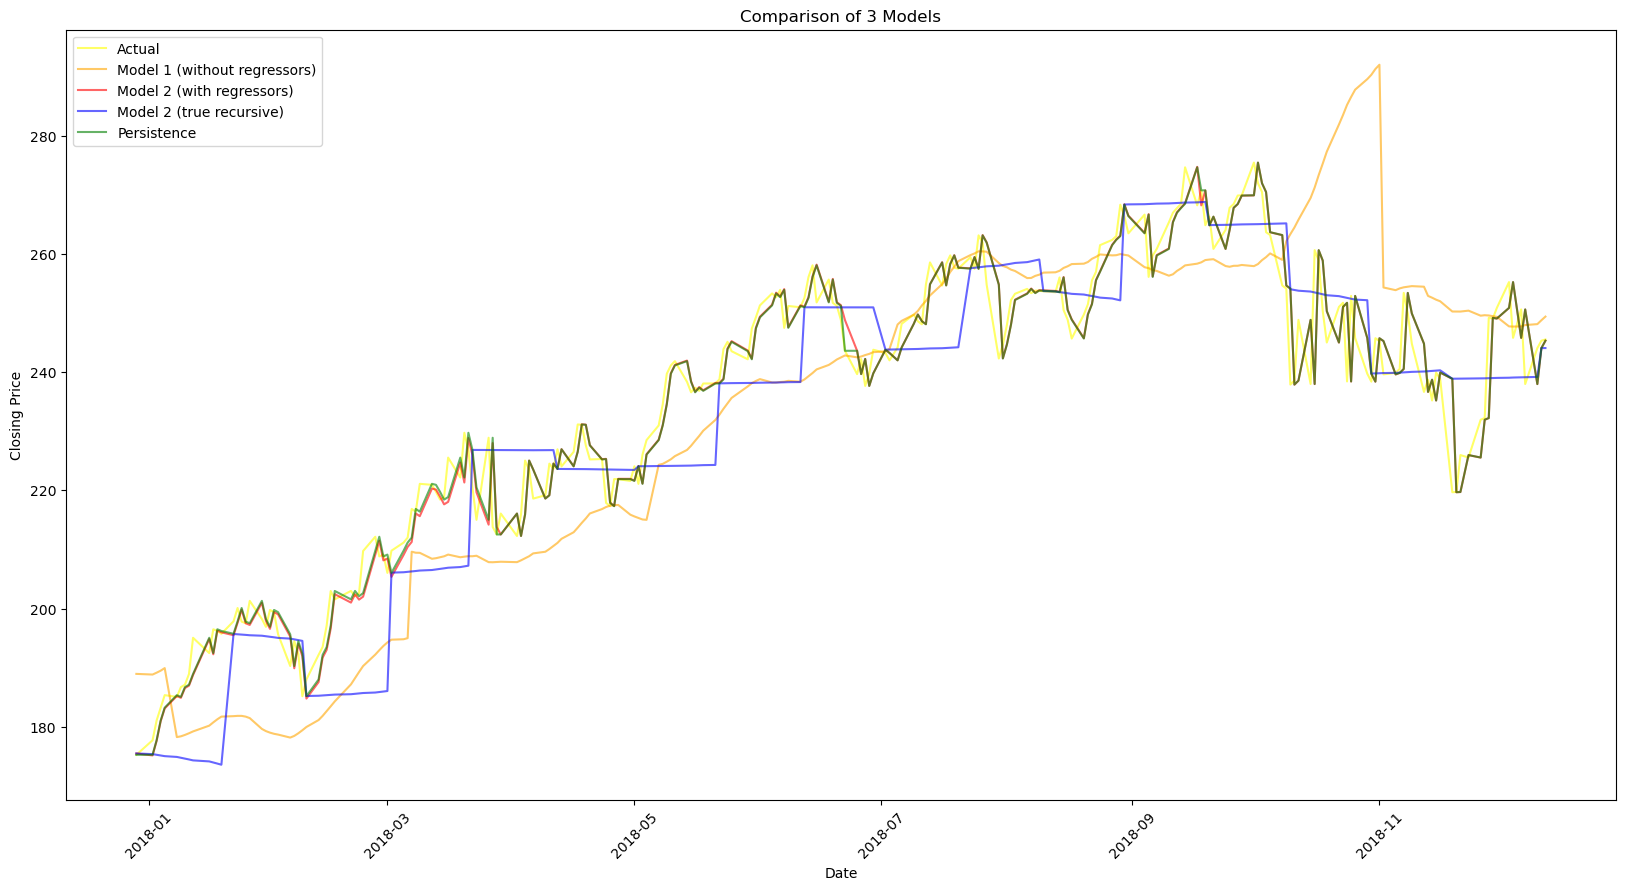

In [58]:
# visualize all 3 models' predictions side by side
plt.figure(figsize=(20, 10))
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_actual'], label='Actual', color = 'yellow', alpha = 0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_no_reg'], label='Model 1 (without regressors)', color = 'orange', alpha=0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_with_reg_nr'], label='Model 2 (with regressors)', color = 'red', alpha=0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_with_reg'], label='Model 2 (true recursive)', color = 'blue', alpha=0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_persistence'], label='Persistence', color = 'green', alpha=0.6)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Comparison of 3 Models')
plt.legend()
plt.show()

## Model Comparison
This chart reveals that the non-recursive Model 2 (Red) and the Persistence model (Green) are nearly identical, tracking the actual price (Yellow) very closely using the previous day's actual value. In contrast, the base Model 1 (Orange) is smoothly follwoing the trend, but struggles as the price follows random walk or show random high frequency fluctions driven by different events. And the "True Recursive" model (Blue) quickly fails, as its predictions flatten and diverge, reflecting it's exponentially compounding forecasting errors.

# **Test**
## Test Datset
Now I'll test my model on unseen test data. I'll create a test dataset ranging 2019 to test my models on, and compare with the perssitence model. I'll prepare my test dataset following the same methods as the train dataset.

In [59]:
# Filter a range for model training
start_date_test = '2019-01-01'
end_date_test = '2019-12-31'

# Filter ADBE stock with correct dates
adbe_test = adbe_df[(adbe_df['Date'] >= start_date_test) & (adbe_df['Date'] <= end_date_test)].copy()

adbe_test = adbe_test.set_index('Date')

In [60]:
test_df = adbe_test[['Adjusted Close']].reset_index()
test_df.rename(columns={'Date': 'ds', 'Adjusted Close': 'y'}, inplace=True)
test_df.head(n=20)

,ds,y
0,2019-01-02,224.570007
1,2019-01-03,215.699997
2,2019-01-04,226.190002
3,2019-01-07,229.259995
4,2019-01-08,232.679993
5,2019-01-09,235.429993
6,2019-01-10,237.770004
7,2019-01-11,237.550003
8,2019-01-14,234.559998
9,2019-01-15,242.360001


In [61]:
# log transformation
test_df_log = test_df.copy()
test_df_log['y'] = np.log1p(test_df_log['y'])
test_df_log.head(n=10)

,ds,y
0,2019-01-02,5.418631
1,2019-01-03,5.378514
2,2019-01-04,5.425787
3,2019-01-07,5.439209
4,2019-01-08,5.453953
5,2019-01-09,5.465652
6,2019-01-10,5.475501
7,2019-01-11,5.474579
8,2019-01-14,5.461966
9,2019-01-15,5.494542


In [62]:
# Use test_df_log directly (log-transformed 'y')
print(f"\nTest data: {len(test_df_log)} points")
print(f"Date range: {test_df_log['ds'].min().date()} to {test_df_log['ds'].max().date()}")


Test data: 252 points
Date range: 2019-01-02 to 2019-12-31


## Model 1 Test
I'll test Model 1 on the test dataset. And I'll compare the results with the persistence model across multiple horizons. Since my Model 1 will be predicting the horizons only with train dataset's insight, I'll be using a static persistence model for a fair comparison. This means, same as the Model 1, the persistence model will not recieve daily updates of price data, and will remain static with the assumption of the first data point of the test dataset.

In [63]:
# Test model_1 across multiple horizons
print(f"\nTesting Prophet Model 1 on {len(test_df_log)} test data points")
print("=" * 80)

# Define horizons to test
horizons = [7, 14, 30, 60, 91, 183, 252, 365] # here, although the whole period is 365 days, there's actually 252 data points (trading days)

# Storage for results
horizon_results = []

for horizon in horizons:
   # Check if we have enough test data for this horizon
    if horizon > len(test_df_log):
        print(f"Skipping horizon {horizon} - insufficient test data")
        continue
 
    # Get test subset for this horizon
    test_subset = test_df_log.iloc[:horizon].copy()
 
    # MODEL 1 PREDICTION
    forecast_test = model_1.predict(test_subset)

    # Transform predictions
    y_true = np.expm1(test_subset['y'].values)
    y_pred = np.expm1(forecast_test['yhat'].values)
    y_lower = np.expm1(forecast_test['yhat_lower'].values)
    y_upper = np.expm1(forecast_test['yhat_upper'].values)

    # PERSISTENCE PREDICTION (static)
    # Use first test value as baseline for all predictions
    last_known_log = test_df_log['y'].iloc[0]
    y_pred_pers = np.full(horizon, np.expm1(last_known_log))

    # Calculate metrics for Model 1
    mae_model = mean_absolute_error(y_true, y_pred)
    rmse_model = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_model = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2_model = r2_score(y_true, y_pred)

    # Coverage metrics
    in_interval = np.sum((y_true >= y_lower) & (y_true <= y_upper))
    coverage_pct = (in_interval / len(y_true)) * 100
    avg_width_pct = np.mean((y_upper - y_lower) / y_true) * 100

    # Calculate metrics for Persistence
    mae_pers = mean_absolute_error(y_true, y_pred_pers)
    rmse_pers = np.sqrt(mean_squared_error(y_true, y_pred_pers))
    mape_pers = np.mean(np.abs((y_true - y_pred_pers) / (y_true + 1e-8))) * 100
    r2_pers = r2_score(y_true, y_pred_pers)

    # Store results
    horizon_results.append({
        'horizon': horizon,
        'mae_model': mae_model,
        'rmse_model': rmse_model,
        'mape_model': mape_model,
        'r2_model': r2_model,
        'coverage': coverage_pct,
        'avg_width': avg_width_pct,
        'mae_pers': mae_pers,
        'rmse_pers': rmse_pers,
        'mape_pers': mape_pers,
        'r2_pers': r2_pers
    })

    # Print results for this horizon
    print(f"\n{'='*80}")
    print(f"HORIZON: {horizon} days")
    print(f"{'='*80}")
    print(f"\n{'Model 1 (Prophet)':>20} | {'Persistence':>20}")
    print(f"{'-'*80}")
    print(f"{'MAE:':<15} {mae_model:>12.3f} | {mae_pers:>20.3f}")
    print(f"{'RMSE:':<15} {rmse_model:>12.3f} | {rmse_pers:>20.3f}")
    print(f"{'MAPE:':<15} {mape_model:>11.2f}% | {mape_pers:>19.2f}%")
    print(f"{'R²:':<15} {r2_model:>12.4f} | {r2_pers:>20.4f}")
    print(f"\n{'Prophet Coverage:':<25} {coverage_pct:.1f}%")
    print(f"{'Prophet Avg Width:':<25} {avg_width_pct:.1f}%")

# Create summary DataFrame
results_df = pd.DataFrame(horizon_results)

print(f"\n{'='*80}")
print("SUMMARY: Model 1 vs Persistence Across All Horizons")
print(f"{'='*80}\n")
print(results_df.to_string(index=False))

# Calculate improvement percentages
results_df['mae_improvement'] = ((results_df['mae_pers'] - results_df['mae_model']) / results_df['mae_pers']) * 100
results_df['rmse_improvement'] = ((results_df['rmse_pers'] - results_df['rmse_model']) / results_df['rmse_pers']) * 100
results_df['mape_improvement'] = ((results_df['mape_pers'] - results_df['mape_model']) / results_df['mape_pers']) * 100

print(f"\n{'='*80}")
print("IMPROVEMENT OF MODEL 1 OVER PERSISTENCE (% better)")
print(f"{'='*80}\n")
print(results_df[['horizon', 'mae_improvement', 'rmse_improvement', 'mape_improvement']].to_string(index=False))



Testing Prophet Model 1 on 252 test data points

HORIZON: 7 days

   Model 1 (Prophet) |          Persistence
--------------------------------------------------------------------------------
MAE:                   4.466 |                6.764
RMSE:                  5.643 |                8.117
MAPE:                  1.97% |                2.93%
R²:                   0.3366 |              -0.3728

Prophet Coverage:         100.0%
Prophet Avg Width:        11.3%

HORIZON: 14 days

   Model 1 (Prophet) |          Persistence
--------------------------------------------------------------------------------
MAE:                   4.790 |               11.967
RMSE:                  5.656 |               13.730
MAPE:                  2.04% |                5.00%
R²:                   0.5679 |              -1.5465

Prophet Coverage:         100.0%
Prophet Avg Width:        12.0%

HORIZON: 30 days

   Model 1 (Prophet) |          Persistence
-----------------------------------------------------

## Metrics Comparison (Model 1 vs Persistence (Static))
Model 1 (Prophet) is significantly superior to a static persistence model for any forecast horizon, achieving a high percentage of error reduction. Model 1's R² is mostly positive (e.g., 0.64 at 91 days) versus the persistence model's consistently negative R². However, its 100% coverage is due to the increasing average width. This is due to Prophet's default setting, where the farther into the future it forecasts, the higher the average width, reflecting high uncertainty in long-range forecasts.

## Model 2 Test
Now i'll test my Model 2 against a rolling persistence model. As both the models recieve daily updates of the data, it'll show a fair comparison between both the model's abilities.
For this I'll first train both the persistence model and my Model 2 with the same parameters as before (as the previous method trained multiple models across varying horizons and resulted in a predictions dataframe). Then I'll test and compare them similarly as before.

In [64]:
# TESTING PERSISTENCE MODEL ON TEST SET (1 YEAR - ROLLING)
print("="*80)
print("TESTING PERSISTENCE MODEL ON TEST SET (Rolling 1-step-ahead)")
print("="*80)

# Persistence: predicted log y = previous log y 
# Use the *last* log value from the TRAINING SET for the *first* prediction
y_pred_log_pers = test_df_log['y'].shift(1).fillna(train_df_log['y'].iloc[-1])

# Reverse transform to original scale
y_true = np.expm1(test_df_log['y'].values)
y_pred = np.expm1(y_pred_log_pers.values)

# Calculate Metrics for the entire test set
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
r2 = r2_score(y_true, y_pred)

print("\n" + "="*80)
print("TEST SET RESULTS - PERSISTENCE MODEL (Rolling)")
print("="*80)
print(f"\nMAE = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"MAPE = {mape:.3f}%")
print(f"R² = {r2:.4f}")

# Store predictions in a DataFrame
test_predictions_persistence = pd.DataFrame({
    'ds': test_df_log['ds'],
    'y_actual': y_true,
    'y_pred': y_pred
})
print(f"Predictions stored in DataFrame: 'test_predictions_persistence'")
print("="*80)

TESTING PERSISTENCE MODEL ON TEST SET (Rolling 1-step-ahead)

TEST SET RESULTS - PERSISTENCE MODEL (Rolling)

MAE = 3.081
RMSE = 4.136
MAPE = 1.114%
R² = 0.9637
Predictions stored in DataFrame: 'test_predictions_persistence'


In [65]:
# Model 2 final training on all training datapoints
print("="*80)
print("Training a final Model 2 on all 2014-2018 data")
print("="*80)

# Prepare training data with the regressors
train_df_reg = train_df_log.copy()

# Define the specified regressors
train_df_reg['lag1'] = train_df_reg['y'].shift(1)
train_df_reg['lag7'] = train_df_reg['y'].shift(7)
train_df_reg['sma_30'] = train_df_reg['y'].rolling(window=30, min_periods=1).mean()
train_df_reg['volatility_30'] = train_df_reg['y'].rolling(window=30, min_periods=1).std()
train_df_reg['trend_strength'] = train_df_reg['y'] - train_df_reg['sma_30']

# Drop NaNs created by shifting
train_df_reg_clean = train_df_reg.dropna()
regressors = ['lag1', 'lag7', 'sma_30', 'volatility_30', 'trend_strength']

print(f"Training data prepared with {len(regressors)} regressors.")

# Initialize and Fit the Model
holidays = make_holidays_df(year_list=range(1986, 2022), country='US')
final_model_2 = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive',
    changepoint_prior_scale=1,  
    interval_width=0.95,
    uncertainty_samples=1000,
    seasonality_prior_scale=0.1,
    holidays=holidays
)

for reg in regressors:
    final_model_2.add_regressor(reg)
final_model_2.add_seasonality(name='quarterly', period=91.3, fourier_order=5)

print("Fitting final_model_2")
final_model_2.fit(train_df_reg_clean)

print(" Final Model 2 is trained.")

Training a final Model 2 on all 2014-2018 data
Training data prepared with 5 regressors.


00:04:18 - cmdstanpy - INFO - Chain [1] start processing


Fitting final_model_2


00:04:19 - cmdstanpy - INFO - Chain [1] done processing


 Final Model 2 is trained.


In [66]:
print("\n" + "="*80)
print("Generating 1-step-ahead (Non-Recursive) predictions")
print("="*80)

# Combine train and test data to easily get 'actual' history
full_history_log = pd.concat([train_df_log, test_df_log]).reset_index(drop=True)
test_start_index = len(train_df_log)

model_2_nr_predictions = []

for i in range(test_start_index, len(full_history_log)):
    # Get the single day we want to predict
    future_step_df = pd.DataFrame({'ds': [full_history_log.iloc[i]['ds']]})
    
    # Get all actual history up to the day before
    history_array = full_history_log.iloc[:i]['y'].values
    
    # Calculate the regressors based on actual history  
    future_step_df['lag1'] = history_array[-1]
    future_step_df['lag7'] = history_array[-7]
    future_step_df['sma_30'] = history_array[-30:].mean()
    future_step_df['volatility_30'] = np.std(history_array[-30:])
    future_step_df['trend_strength'] = history_array[-1] - history_array[-30:].mean()
    
    # Make the 1-step-ahead prediction
    forecast_step = final_model_2.predict(future_step_df)
    model_2_nr_predictions.append(forecast_step)

# Store the Non-Recursive predictions
forecast_df_nr = pd.concat(model_2_nr_predictions).reset_index(drop=True)

# Create the final results DataFrame aligned with test_df_log
test_predictions_model_2_nr = pd.DataFrame({
    'ds': test_df_log['ds'],
    'y_actual': np.expm1(test_df_log['y']),
    'y_pred': np.expm1(forecast_df_nr['yhat']),
    'yhat_lower': np.expm1(forecast_df_nr['yhat_lower']),
    'yhat_upper': np.expm1(forecast_df_nr['yhat_upper'])
})

print("1-step-ahead predictions generated and stored.")


Generating 1-step-ahead (Non-Recursive) predictions
1-step-ahead predictions generated and stored.


In [67]:
# Compare Model 2 (Non-Recursive) vs. Persistence (Rolling)
print(f"\n{'='*80}")
print(f"Comparing Model 2 (Non-Recursive) vs. Persistence (Rolling)")
print(f"{'='*80}")

# Load the two prediction dataframes
try:
    model_2_results = test_predictions_model_2_nr.copy()
    persistence_results = test_predictions_persistence.copy()
except NameError:
    print("ERROR: 'test_predictions_model_2_nr' or 'test_predictions_persistence' not found.")
    print("Please ensure the previous block ran and that the persistence model predictions are in memory.")

# Align the two dataframes
model_2_results = model_2_results.iloc[1:].reset_index(drop=True)
persistence_results = persistence_results.iloc[1:].reset_index(drop=True)

print(f"Dataframes are aligned and comparing {len(model_2_results)} data points.")

# Define horizons and run the comparison loop 
max_days = len(model_2_results)
horizons = [7, 14, 30, 60, 91, 183, 251]
if max_days not in horizons and max_days > 183:
    horizons.append(max_days)

horizon_results_list = []

for horizon in horizons:
    if horizon > max_days: continue
    
    model_2_slice = model_2_results.iloc[:horizon]
    persistence_slice = persistence_results.iloc[:horizon]
    
    y_true = model_2_slice['y_actual'].values
    
    # Model 2 (Non-Recursive) metrics
    y_pred_m2 = model_2_slice['y_pred'].values
    y_lower = model_2_slice['yhat_lower'].values
    y_upper = model_2_slice['yhat_upper'].values
    
    mae_model = mean_absolute_error(y_true, y_pred_m2)
    rmse_model = np.sqrt(mean_squared_error(y_true, y_pred_m2))
    mape_model = np.mean(np.abs((y_true - y_pred_m2) / (y_true + 1e-8))) * 100
    r2_model = r2_score(y_true, y_pred_m2)
    
    in_interval = np.sum((y_true >= y_lower) & (y_true <= y_upper))
    coverage_pct = (in_interval / len(y_true)) * 100
    avg_width_pct = np.mean((y_upper - y_lower) / y_true) * 100
    
    # Persistence (Rolling) metrics
    y_pred_pers = persistence_slice['y_pred'].values
    
    mae_pers = mean_absolute_error(y_true, y_pred_pers)
    rmse_pers = np.sqrt(mean_squared_error(y_true, y_pred_pers))
    mape_pers = np.mean(np.abs((y_true - y_pred_pers) / (y_true + 1e-8))) * 100
    r2_pers = r2_score(y_true, y_pred_pers)
    
    # Store results
    horizon_results_list.append({
        'horizon': horizon,
        'mae_model': mae_model, 'rmse_model': rmse_model, 'mape_model': mape_model, 'r2_model': r2_model,
        'coverage': coverage_pct, 'avg_width': avg_width_pct,
        'mae_pers': mae_pers, 'rmse_pers': rmse_pers, 'mape_pers': mape_pers, 'r2_pers': r2_pers
    })
    
    # Print results for this horizon
    print(f"\n{'='*80}")
    print(f"HORIZON: {horizon} days (Cumulative)")
    print(f"{'='*80}")
    print(f"{'Metric':<15} | {'Model 2 (Non-Recursive)':>25} | {'Persistence (Rolling)':>25}")
    print(f"{'-'*80}")
    print(f"{'MAE:':<15} | {mae_model:>25.3f} | {mae_pers:>25.3f}")
    print(f"{'RMSE:':<15} | {rmse_model:>25.3f} | {rmse_pers:>25.3f}")
    print(f"{'MAPE:':<15} | {mape_model:>24.2f}% | {mape_pers:>24.2f}%")
    print(f"{'R²:':<15} | {r2_model:>25.4f} | {r2_pers:>25.4f}")
    print(f"\n{'Model 2 Coverage:':<25} {coverage_pct:.1f}%")
    print(f"{'Model 2 Avg Width:':<25} {avg_width_pct:.1f}%")

# Create summary DataFrame
results_df_2 = pd.DataFrame(horizon_results_list)

print(f"\n{'='*80}")
print("SUMMARY: Model 2 (Non-Recursive) vs. Persistence (Rolling) Across All Horizons")
print(f"{'='*80}\n")
print(results_df_2.to_string(index=False))

# Calculate improvement percentages
results_df_2['mae_improvement'] = ((results_df_2['mae_pers'] - results_df_2['mae_model']) / results_df_2['mae_pers']) * 100
results_df_2['rmse_improvement'] = ((results_df_2['rmse_pers'] - results_df_2['rmse_model']) / results_df_2['rmse_pers']) * 100
results_df_2['mape_improvement'] = ((results_df_2['mape_pers'] - results_df_2['mape_model']) / results_df_2['mape_pers']) * 100

print(f"\n{'='*80}")
print("IMPROVEMENT OF MODEL 2 OVER ROLLING PERSISTENCE (% better)")
print(f"{'='*80}\n")
print(results_df_2[['horizon', 'mae_improvement', 'rmse_improvement', 'mape_improvement']].to_string(index=False))


Comparing Model 2 (Non-Recursive) vs. Persistence (Rolling)
Dataframes are aligned and comparing 251 data points.

HORIZON: 7 days (Cumulative)
Metric          |   Model 2 (Non-Recursive) |     Persistence (Rolling)
--------------------------------------------------------------------------------
MAE:            |                     4.450 |                     4.451
RMSE:           |                     5.642 |                     5.643
MAPE:           |                     1.97% |                     1.97%
R²:             |                    0.3987 |                    0.3985

Model 2 Coverage:         14.3%
Model 2 Avg Width:        0.4%

HORIZON: 14 days (Cumulative)
Metric          |   Model 2 (Non-Recursive) |     Persistence (Rolling)
--------------------------------------------------------------------------------
MAE:            |                     3.775 |                     3.776
RMSE:           |                     4.806 |                     4.808
MAPE:           |     

## Metrics Comparison (Model 2 vs Persistence (Rolling))
This analysis proves that the non-recursive Model 2 is functionally identical to a simple rolling persistence model. Across all horizons, the error metrics (MAE, RMSE, MAPE) and R² are almost the same, with Model 2 consistently showing slight improvements. However, the model is catastrophically overconfident, with its prediction interval coverage never exceeding 20% due a very narrow average width.